In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [54]:
with open('../data/molecules.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [55]:
structures = pd.read_feather('../data/structures_enh.feather')
molecules_df = pd.read_feather('../data/molecules.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [56]:
labelled_enh = labelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
labelled_enh.head(32)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,nC,nF,nH,nN,nO,nCNOF,nCN,nOF,nAtoms
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807602,1,0,4,0,0,1,1,0,5
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,1,0,4,0,0,1,1,0,5
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800,1,0,4,0,0,1,1,0,5
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300,1,0,4,0,0,1,1,0,5
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807404,1,0,4,0,0,1,1,0,5
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.254100,1,0,4,0,0,1,1,0,5
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.254800,1,0,4,0,0,1,1,0,5
7,7,dsgdb9nsd_000001,3,0,1JHC,84.809303,1,0,4,0,0,1,1,0,5
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.254300,1,0,4,0,0,1,1,0,5
9,9,dsgdb9nsd_000001,4,0,1JHC,84.809502,1,0,4,0,0,1,1,0,5


In [75]:
unlabelled_enh = unlabelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
unlabelled_enh.head(32)

,id,molecule_name,atom_index_0,atom_index_1,type,nC,nF,nH,nN,nO,nCNOF,nCN,nOF,nAtoms
0,4658147,dsgdb9nsd_000004,2,0,2JHC,2,0,2,0,0,2,2,0,4
1,4658148,dsgdb9nsd_000004,2,1,1JHC,2,0,2,0,0,2,2,0,4
2,4658149,dsgdb9nsd_000004,2,3,3JHH,2,0,2,0,0,2,2,0,4
3,4658150,dsgdb9nsd_000004,3,0,1JHC,2,0,2,0,0,2,2,0,4
4,4658151,dsgdb9nsd_000004,3,1,2JHC,2,0,2,0,0,2,2,0,4
5,4658152,dsgdb9nsd_000015,3,0,1JHC,2,0,6,0,1,3,2,1,9
6,4658153,dsgdb9nsd_000015,3,2,3JHC,2,0,6,0,1,3,2,1,9
7,4658154,dsgdb9nsd_000015,3,4,2JHH,2,0,6,0,1,3,2,1,9
8,4658155,dsgdb9nsd_000015,3,5,2JHH,2,0,6,0,1,3,2,1,9
9,4658156,dsgdb9nsd_000015,4,0,1JHC,2,0,6,0,1,3,2,1,9


In [57]:
len(labelled), len(labelled_enh)

(4658147, 4658147)

In [58]:
from models import SKModel, partition_data

#data_df = labelled[labelled.type == '1JHC'].head(10)
data_df = labelled_enh.head(1000)
train_df, test_df = partition_data(data_df, train_frac=1)
train_df = train_df.copy()
        
model = SKModel(molecules=molecules,
                structures=structures)
model.corr(train_df, train_df)

,id,atom_index_0,atom_index_1,scalar_coupling_constant,nC,nF,nH,nN,nO,nCNOF,...,atom3_dist_to_mean,bond01_dist,bond01_valency,bond01_strength,bond12_dist,bond12_valency,bond12_strength,bond23_dist,bond23_valency,bond23_strength
id,1.000000,0.406918,0.041697,-0.016962,0.546672,NaN,0.103696,0.250864,0.184376,0.877666,...,0.004481,-0.074390,NaN,0.011294,0.071836,0.050569,0.029803,0.118942,0.049380,0.045188
atom_index_0,0.406918,1.000000,0.011735,0.021135,0.518762,NaN,0.498438,-0.063654,-0.078098,0.452681,...,-0.012157,0.033633,NaN,0.091144,0.043758,0.033210,0.003153,0.080783,0.021872,0.004759
atom_index_1,0.041697,0.011735,1.000000,-0.327123,0.124382,NaN,0.187484,-0.078899,-0.082226,0.021650,...,0.046203,0.088245,NaN,-0.011439,0.269809,0.241408,0.338199,0.178053,0.223684,0.310136
scalar_coupling_constant,-0.016962,0.021135,-0.327123,1.000000,-0.037820,NaN,-0.137119,-0.017115,0.066874,-0.007841,...,-0.105823,0.041626,NaN,-0.034784,-0.873809,-0.757886,-0.838291,-0.295839,-0.271669,-0.283859
nC,0.546672,0.518762,0.124382,-0.037820,1.000000,NaN,0.588642,-0.287826,-0.331754,0.636281,...,0.030987,0.190717,NaN,0.071808,0.121409,0.107623,0.095275,0.144087,0.127151,0.118173
nF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nH,0.103696,0.498438,0.187484,-0.137119,0.588642,NaN,1.000000,-0.398714,-0.327402,0.125472,...,0.031182,0.260547,NaN,0.091020,0.135872,-0.004790,0.030709,0.119962,0.060040,0.081332
nN,0.250864,-0.063654,-0.078899,-0.017115,-0.287826,NaN,-0.398714,1.000000,-0.172921,0.285675,...,-0.002220,-0.289489,NaN,-0.293279,-0.009912,-0.028754,-0.061208,0.018791,-0.016574,-0.029746
nO,0.184376,-0.078098,-0.082226,0.066874,-0.331754,NaN,-0.327402,-0.172921,1.000000,0.188792,...,-0.049549,-0.076826,NaN,0.193143,-0.060728,-0.040472,-0.031660,-0.038037,-0.066832,-0.063948
nCNOF,0.877666,0.452681,0.021650,-0.007841,0.636281,NaN,0.125472,0.285675,0.188792,1.000000,...,-0.001555,-0.052983,NaN,-0.002851,0.081359,0.066890,0.036773,0.140621,0.078702,0.061820


In [59]:
model.structures.columns

Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z', 'x_mean',
       'y_mean', 'z_mean', 'dist_to_mean'],
      dtype='object')

In [60]:
model.input_df.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'nC', 'nF', 'nH', 'nN', 'nO', 'nCNOF',
       'nCN', 'nOF', 'nAtoms', 'coupling_distance', 'atom_0', 'atom_1',
       'coupling_1JHN', 'coupling_2JHC', 'coupling_2JHH', 'coupling_3JHC',
       'coupling_3JHH', 'coupling_2JHN', 'coupling_3JHN', 'coupling_1JHC',
       'atom0_O', 'atom0_N', 'atom0_H', 'atom0_F', 'atom0_C', 'atom0_weight',
       'ai', 'atom0_dist_to_mean', 'atomN_O', 'atomN_N', 'atomN_H', 'atomN_F',
       'atomN_C', 'atomN_weight', 'atomN_dist_to_mean', 'atom1_O', 'atom1_N',
       'atom1_H', 'atom1_F', 'atom1_C', 'atom1_weight', 'atom1_dist_to_mean',
       'atom2_O', 'atom2_N', 'atom2_H', 'atom2_F', 'atom2_C', 'atom2_weight',
       'atom2_dist_to_mean', 'atom3_O', 'atom3_N', 'atom3_H', 'atom3_F',
       'atom3_C', 'atom3_weight', 'atom3_dist_to_mean', 'bond01_dist',
       'bond01_valency', 'bond01_strength', 'bond12_dist', 'bond12_valency',
       'bond12_strengt

In [61]:
model.input_df.dtypes

id                             int32
molecule_name                 object
atom_index_0                   int16
atom_index_1                   int16
type                        category
scalar_coupling_constant     float32
nC                              int8
nF                              int8
nH                              int8
nN                              int8
nO                              int8
nCNOF                           int8
nCN                             int8
nOF                             int8
nAtoms                          int8
coupling_distance            float32
atom_0                      category
atom_1                      category
coupling_1JHN                   int8
coupling_2JHC                   int8
coupling_2JHH                   int8
coupling_3JHC                   int8
coupling_3JHH                   int8
coupling_2JHN                   int8
coupling_3JHN                   int8
coupling_1JHC                   int8
atom0_O                         int8
a

In [63]:
labelled_enh.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,nC,nF,nH,nN,nO,nCNOF,nCN,nOF,nAtoms
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807602,1,0,4,0,0,1,1,0,5
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,1,0,4,0,0,1,1,0,5
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800,1,0,4,0,0,1,1,0,5
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300,1,0,4,0,0,1,1,0,5
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807404,1,0,4,0,0,1,1,0,5


In [43]:
import itertools

Training 5835 samples for 1JHC
1JHC score: 1.4961174357637284 (trained on 5835 elements)
Training 468 samples for 1JHN
1JHN score: 0.7872055998556188 (trained on 468 elements)
Training 8262 samples for 2JHC
2JHC score: 0.5549983365554217 (trained on 8262 elements)
Training 3786 samples for 2JHH
2JHH score: 0.4838591307561683 (trained on 3786 elements)
Training 912 samples for 2JHN
2JHN score: 0.23020382889946361 (trained on 912 elements)
Training 10052 samples for 3JHC
3JHC score: 0.7463038682637991 (trained on 10052 elements)
Training 4414 samples for 3JHH
3JHH score: 1.0638197792798982 (trained on 4414 elements)
Training 1266 samples for 3JHN
3JHN score: -0.17013709000421254 (trained on 1266 elements)


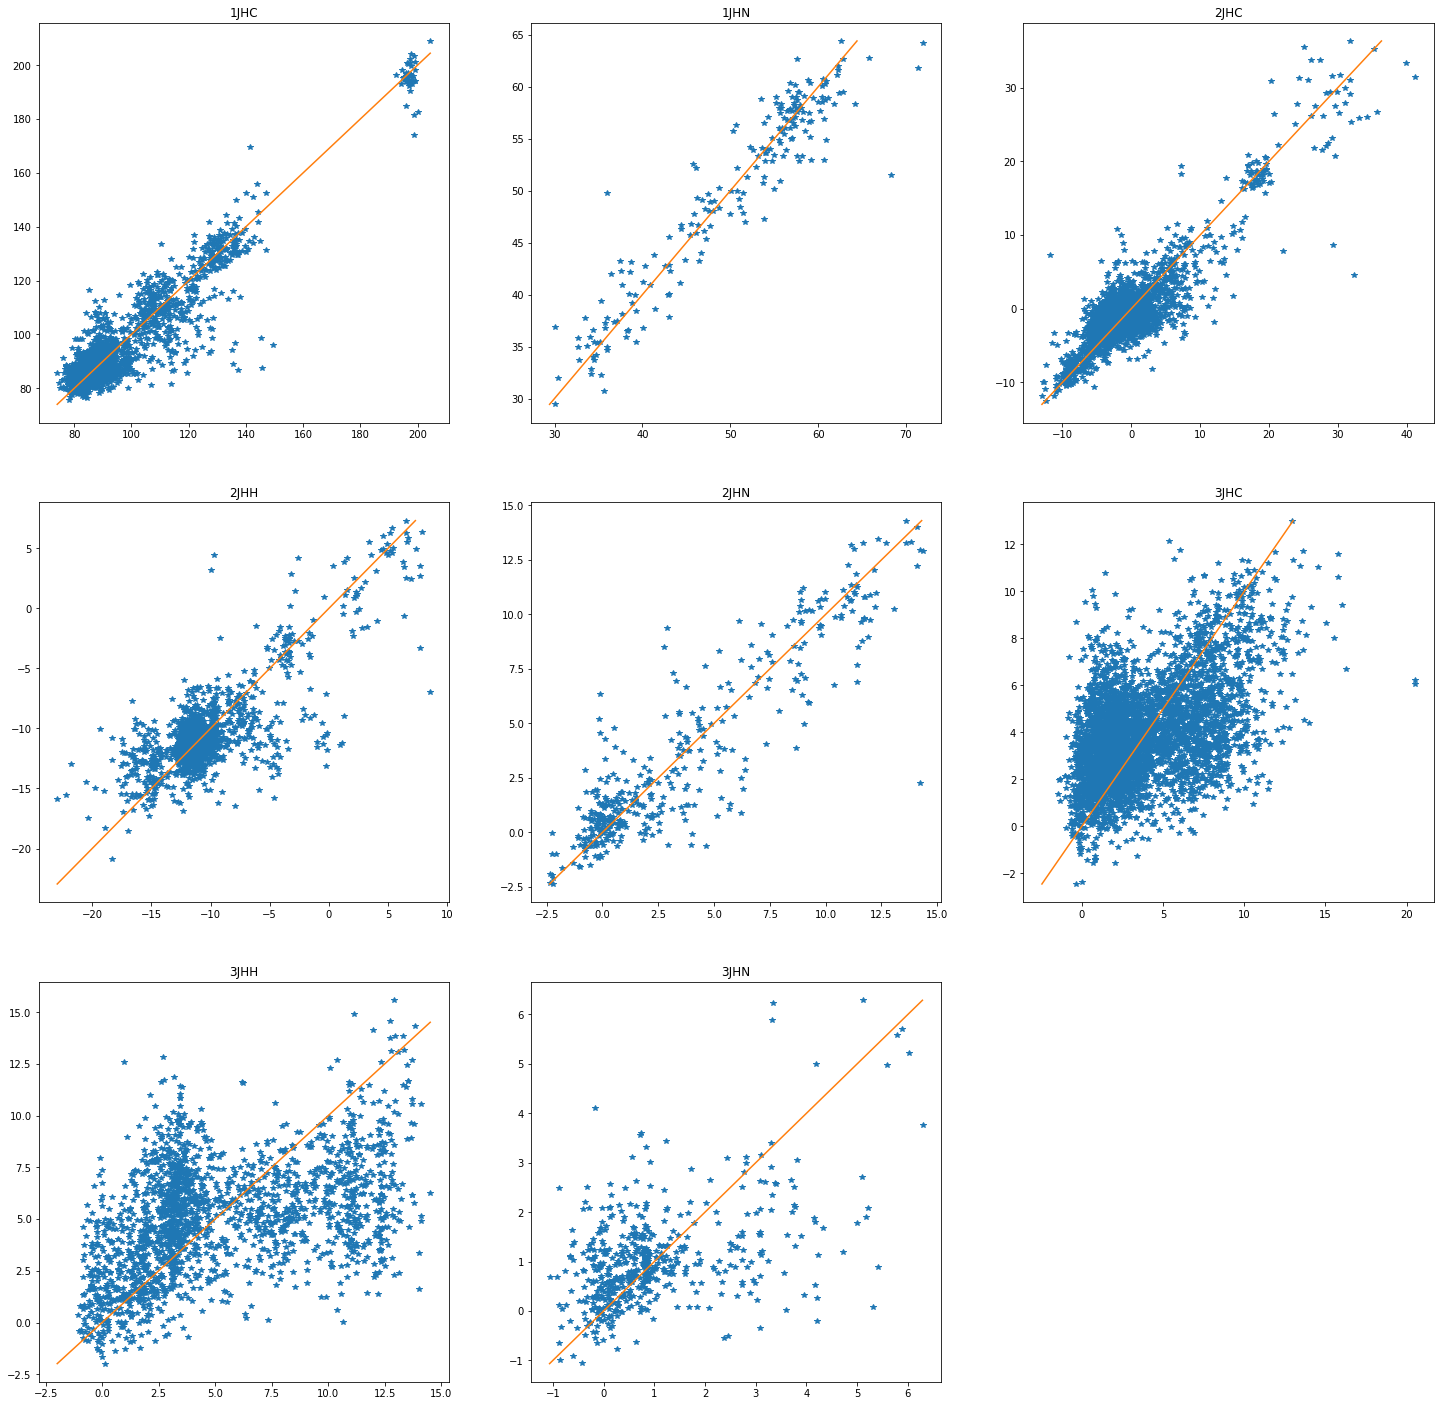

In [74]:
from models import XGBModel, LGBModel
from models import partition_data

# atom_count_ranges = [(1, 10), (11, 15), (16, 20), (21, 25), (26, 30)]
# C_count_ranges = [(1, 5), (6, 6), (7, 7), (8, 9)]
coupling_types = sorted(labelled_enh.type.unique())
def test(data):
    plt.figure(figsize=(25, 25))
#     for i, (t, (min_atoms, max_atoms)) in enumerate(itertools.product(coupling_types, C_count_ranges), 1):
    for i, t in enumerate(coupling_types, 1):    
#         data_df = data[(data.type == t) & (data.nC >= min_atoms) & (data.nC <= max_atoms)]
        data_df = data[data.type == t]

        train_df, test_df = partition_data(data_df)
        
        if len(train_df) < 10 or len(test_df) < 10:
            continue
            
        print(f'Training {len(train_df)} samples for {t}')

        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         dict(n_jobs=8,
                              max_depth=9,
                              boosting_type='gbdt',
                              num_leaves=128,
                              min_child_samples=20,
                              learning_rate=0.2,
                              n_estimators=1000,
                              reg_alpha=0.1,
                              reg_lambda=0.3,
                              subsample_freq = 1,
                              subsample = 0.9,
#                               verbose=500
                             ))
  
        model.fit(train_df, train_df)
        output, score = model.evaluate(test_df, test_df)
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')
        plt.subplot(3, 3, i)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())
        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
    plt.show()
        
test(labelled_enh.head(50000))


In [76]:
def train(data):
    models = {}
    for t in sorted(data.type.unique()):
        train_df = data[data.type == t]
        print(f'Training {len(train_df)} samples for {t}')
        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         dict(n_jobs=8,
                              max_depth=9,
                              boosting_type='gbdt',
                              num_leaves=128,
                              min_child_samples=20,
                              learning_rate=0.2,
                              n_estimators=1000,
                              reg_alpha=0.1,
                              reg_lambda=0.3,
                              subsample_freq = 1,
                              subsample = 0.9))
        models[t] = model
        model.fit(train_df, train_df)
    
    return models

models = train(labelled_enh)

Training 709416 samples for 1JHC
Training 43363 samples for 1JHN
Training 1140674 samples for 2JHC
Training 378036 samples for 2JHH
Training 119253 samples for 2JHN
Training 1510379 samples for 3JHC
Training 590611 samples for 3JHH
Training 166415 samples for 3JHN


In [77]:
def predict(data, models):
    out_df = None
    
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        print(f'Predicting {len(predict_df)} samples for {t}')
        output = models[t].predict(predict_df)
        
        id = predict_df['id']
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output}, index=predict_df.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
    
#%prun -s cumulative f(unlabelled.head(10000))
prediction = predict(unlabelled_enh, models)

Predicting 380609 samples for 1JHC
Predicting 24195 samples for 1JHN
Predicting 613138 samples for 2JHC
Predicting 203126 samples for 2JHH
Predicting 64424 samples for 2JHN
Predicting 811999 samples for 3JHC
Predicting 317435 samples for 3JHH
Predicting 90616 samples for 3JHN


In [78]:
prediction.head()

,id,scalar_coupling_constant
0,4658147,22.118632
1,4658148,176.667458
2,4658149,1.159069
3,4658150,176.667458
4,4658151,22.118632


In [79]:
prediction.to_csv('../data/pred.csv',index=False)